## Setup

In [11]:
%matplotlib inline

In [12]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pandas as pd
import statistics
from data_utils import DatasetBuilder
from metrics_utils import compute_metrics, describe_metrics, get_test_metrics, test
from plot_utils import plot
from mitigators import NullMitigator, SyntheticMitigator, DIRMitigator, ReweighMitigator, EGMitigator, PRMitigator, CPPMitigator, ROMitigator 
from test_algorithms import TestAlgorithms
from plot_utils import plot_algo_lr, plot_algo
from aif360.metrics import BinaryLabelDatasetMetric
from oversample import label_bias, selection_bias 
from sklearn import preprocessing
from privacy_meter.dataset import Dataset
from aif360.datasets import BinaryLabelDataset
import os
import shutil
import glob
from datetime import datetime

## Arguments & Initializations

In [13]:
# construct argument parser
import argparse
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--data", choices=['adult', 'compas', 'german', 'bank', 'meps19', 'grade', 'law_sex', 'law_race', 'law_aif_gender', 'law_aif_race'], default='compas', help="dataset: adult, compas, german, bank, meps19, grade")
ap.add_argument("-c", "--classifier", choices=['lr', 'rf', 'svm', 'nn', 'nb'], default='lr', help="baseline model: lr, rf, svm, nn, nb, dt")
ap.add_argument("-m", "--mitigator", choices=['dir', 'rew', 'egr', 'pr', 'cpp', 'ro'], required=False, help="mitigators: dir, rew, egr, pr, cpp, ro")
ap.add_argument("-b", "--bias", default=0., help="amount of bias: o-1")
ap.add_argument("-t", "--biastype", choices=['label', 'selection', 'none'], default='none', help="amount of bias: o-1")
ap.add_argument("-o", "--os", default=2, help="oversample mode: 1: privi unfav 2: unpriv fav")
ap.add_argument("-a", "--attack", choices=['mia1', 'mia2'], default='mia1', help="attacks: our implementation, their implementation")

_StoreAction(option_strings=['-a', '--attack'], dest='attack', nargs=None, const=None, default='mia1', type=None, choices=['mia1', 'mia2'], required=False, help='attacks: our implementation, their implementation', metavar=None)

In [14]:
sys.argv = ['']
args = vars(ap.parse_args())

In [15]:
args

{'data': 'compas',
 'classifier': 'lr',
 'mitigator': None,
 'bias': 0.0,
 'biastype': 'none',
 'os': 2,
 'attack': 'mia1'}

In [16]:
DATASET = "german_age"
BASELINE = "dprf" 
MITIGATOR = args["mitigator"]
BIAS = float(args["bias"])
BIAS_TYPE = args["biastype"]
OS_MODE = 2
ATTACK = "mia1"

In [17]:
# global constants
if BASELINE == 'svm' or BASELINE == 'nn':
    SCALER = False 
else:
    SCALER = False 
DISPLAY = False 
THRESH_ARR = 0.5

# loop ten times 
N = 20

In [18]:
# percentage of favor and unfavor
priv_metric_orig = defaultdict(float)
favor_metric_orig = defaultdict(float)
favor_metric_transf = defaultdict(float)

# for each pre-processing approach, we create a mia_metric_results
orig_metrics = defaultdict(list)
orig_mia_metrics = defaultdict(list)

transf_metrics = defaultdict(list) 
transf_mia_metrics = defaultdict(list) 

reweigh_metrics = defaultdict(list) 
reweigh_mia_metrics = defaultdict(list) 

dir_metrics = defaultdict(list) 
dir_mia_metrics = defaultdict(list) 

eg_metrics = defaultdict(list) 
eg_mia_metrics = defaultdict(list) 

## Loading & Splitting Dataset

In [19]:
DATASET

'german_age'

In [20]:
import os

# Set the directory where the files should be stored
german_data_dir = "/home/temporaryuser2/Desktop/sdp2/OT/mia-privacy-fairness/venv/lib/python3.9/site-packages/aif360/data/raw/german"
os.makedirs(german_data_dir, exist_ok=True)

# URLs of the files to download
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
doc_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc"

# Use wget to download the files
!wget -P {german_data_dir} {data_url}
!wget -P {german_data_dir} {doc_url}

print("Files downloaded successfully.")

--2025-04-01 18:14:30--  https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘/home/temporaryuser2/Desktop/sdp2/OT/mia-privacy-fairness/venv/lib/python3.9/site-packages/aif360/data/raw/german/german.data.2’

german.data.2           [   <=>              ]  77.92K   170KB/s    in 0.5s    

2025-04-01 18:14:32 (170 KB/s) - ‘/home/temporaryuser2/Desktop/sdp2/OT/mia-privacy-fairness/venv/lib/python3.9/site-packages/aif360/data/raw/german/german.data.2’ saved [79793]

--2025-04-01 18:14:32--  https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... conn

In [21]:
# load dataset and set the groups
dataset_builder =  DatasetBuilder(DATASET)
dataset_orig = dataset_builder.load_data()
sens_attr = dataset_orig.protected_attribute_names[0]
unprivileged_groups = dataset_builder.unprivileged_groups
privileged_groups = dataset_builder.privileged_groups

Inside load_data(), self.DATASET = german_age


In [22]:
dataset_orig.features.shape

(1000, 57)

In [23]:
privileged_groups

[{'age': 1}]

In [24]:
sens_attr

'age'

In [25]:
# favorable and unfavorable labels and feature_names
f_label = dataset_orig.favorable_label
uf_label = dataset_orig.unfavorable_label
feature_names = dataset_orig.feature_names

In [26]:
if ATTACK == "mia1":
    # training data split ratio
    p = 0.5
    # split dataset into train, validation, and test
    dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
    dataset_orig_val = dataset_orig_test
    print(dataset_orig_train.features)

    # introduce label or selection biases, assuming the original data is fair
    if BIAS_TYPE == 'label':
        dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
    elif BIAS_TYPE == 'selection':
        dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
    else:
        print('no bias type specified')
        
    dataset_orig_train
    dataset_orig_train?

[[0.29411765 0.1551117  1.         ... 0.         1.         0.        ]
 [0.16176471 0.05298778 1.         ... 1.         1.         0.        ]
 [0.20588235 0.18377902 0.66666667 ... 1.         1.         0.        ]
 ...
 [0.16176471 0.0809398  0.33333333 ... 0.         1.         0.        ]
 [0.38235294 0.23841752 0.33333333 ... 0.         1.         0.        ]
 [0.11764706 0.05227248 1.         ... 1.         1.         0.        ]]
no bias type specified


Type:           BinaryLabelDataset
String form:   
instance weights  features                \
           <...>                 0.0    1.0
           221                            0.0    1.0
           
           [500 rows x 59 columns]
File:           ~/Desktop/sdp2/OT/mia-privacy-fairness/venv/lib/python3.9/site-packages/aif360/datasets/binary_label_dataset.py
Docstring:      Base class for all structured datasets with binary labels.
Init docstring:
Args:
    favorable_label (float): Label value which is considered favorable
        (i.e. "positive").
    unfavorable_label (float): Label value which is considered
        unfavorable (i.e. "negative").
    **kwargs: StructuredDataset arguments.

## Run Mitigating Algorithms

### Setup for MIA2

In [27]:
seed = 1234
np.random.seed(seed)

In [28]:
if ATTACK == "mia2":
    # prepare data format
    X = dataset_orig.features
    y_true = dataset_orig.labels.ravel()
    sens_attr = dataset_orig.protected_attribute_names[0]
    sens_attr_index = dataset_orig.feature_names.index(sens_attr)
    sensitive_features = dataset_orig.features[:, sens_attr_index]

    X_other_features = np.delete(X, sens_attr_index, axis=1)
    X_other_features_normalized = preprocessing.normalize(X_other_features, norm='l2')

    # Reconstruct X by combining the sensitive attribute and the normalized features
    # Insert the sensitive attribute back into its original position
    X_normalized = np.insert(X_other_features_normalized, sens_attr_index, sensitive_features, axis=1)
    X = X_normalized

In [29]:
def get_unique_indices_reference():
    # Determine split sizes proportionally (to sum up to the full dataset size)
    num_train_points = int(X.shape[0] * 0.12)
    num_test_points = int(X.shape[0] * 0.12)
    num_population_points = int(X.shape[0] * 0.3)  # Reduced from 30000

    # Start with all indices
    all_indices = np.arange(X.shape[0])

    # Select train indices without replacement
    train_index = np.random.choice(all_indices, num_train_points, replace=False)
    # Remove train indices from available indices
    remaining_indices = np.setdiff1d(all_indices, train_index)

    # Select test indices from the remaining indices without replacement
    test_index = np.random.choice(remaining_indices, num_test_points, replace=False)
    # Remove test indices from available indices
    remaining_indices = np.setdiff1d(remaining_indices, test_index)

    # Select population indices from the remaining indices (can also choose all remaining points)
    population_index = np.random.choice(remaining_indices, min(num_population_points, len(remaining_indices)), replace=False)
    
    # Summary of counts
    print("==============================================================")
    print("GET UNIQUE INDICES REFERENCE")
    print(f"Number of train points: {len(train_index)}")
    print(f"Number of test points: {len(test_index)}")
    print(f"Number of population points: {len(population_index)}")
    print("==============================================================")
    
    return train_index, test_index, population_index

In [30]:
def create_datasets(train_index, test_index, population_index, g_train, g_test, g_pop_train):
    # create the target model's dataset
    train_ds = {'x': X[train_index], 'y': y_true[train_index],'g':g_train}
    test_ds = {'x': X[test_index], 'y': y_true[test_index], 'g':g_test}
    target_dataset = Dataset(
        data_dict={'train': train_ds, 'test': test_ds},
        default_input='x', default_output='y', default_group='g'
    )

    # create the reference dataset
    population_ds = {'x': X[population_index], 'y': y_true[population_index], 'g': g_pop_train}
    reference_dataset = Dataset(
        data_dict={'train': population_ds},
        default_input='x', default_output='y', default_group='g'
    )
    
    return target_dataset, reference_dataset

In [31]:
# Combine features, labels, and protected attributes into a DataFrame
def create_binary_label_dataset(dataset_orig, X, y, sensitive_features, sens_attr_name, privileged_value, unprivileged_value):
    print("=====================================================")
    print("CREATE BINARY LABEL DATASET")
    # Extract the feature names from the original dataset
    feature_names = dataset_orig.feature_names

    # Create a DataFrame with features, labels, and sensitive attribute
    df = pd.DataFrame(X, columns=feature_names)
    df[dataset_orig.label_names[0]] = y
#     print(df.head())
    # print(dataset_orig.feature_names)
    # print(dataset_orig.features.shape)
    
    # df_orig, _ = dataset_orig.convert_to_dataframe()

    # # Display the first few rows
    # print("Original df's head:", df_orig.head())
    
    # Get the unique labels and their counts
    # unique_labels, counts = np.unique(dataset_orig.labels, return_counts=True)

    # # Print the value counts
    # for label, count in zip(unique_labels, counts):
    #     print(f"Label {label}: {count} instances")

    # Create the BinaryLabelDataset
    dataset = BinaryLabelDataset(
        favorable_label=1.0,  # Adjust as per your dataset
        unfavorable_label=0.0,  # Adjust as per your dataset
        df=df,  # DataFrame containing features, labels, and protected attribute
        label_names=dataset_orig.label_names,  # Column name of labels in DataFrame
        protected_attribute_names=[sens_attr_name],  # Protected attribute column
        privileged_protected_attributes=[privileged_value],  # Privileged group values
        unprivileged_protected_attributes=[unprivileged_value]  # Unprivileged group values
    )
    
    # print(dataset.feature_names)
    # print(dataset.features.shape)
    # # Get the unique labels and their counts
    # unique_labels, counts = np.unique(dataset.labels, return_counts=True)

    # Print the value counts
    # for label, count in zip(unique_labels, counts):
    #     print(f"Label {label}: {count} instances")
    
    print("=====================================================")
    
    return dataset

In [32]:
def delete_logs():
    # Search for directories ending with _group or _pop
    for pattern in ["*_group", "*_pop"]:
        # Find matching directories
        for log_dir in glob.glob(pattern):
            if os.path.exists(log_dir) and os.path.isdir(log_dir):  # Ensure it's a directory
                shutil.rmtree(log_dir)
                print(f"{log_dir} deleted.")

### Calling Both

In [33]:
df, _ = dataset_orig.convert_to_dataframe()

In [34]:
# target_dataset = None
# reference_dataset = None

In [35]:
import warnings
warnings.filterwarnings("ignore")

In [36]:
def prepare_datasets():
    target_dataset = None
    reference_dataset = None
    
    if ATTACK == "mia1":
        # split dataset into train, validation, and test
        dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
        dataset_orig_val = dataset_orig_test

    elif ATTACK == "mia2":
        train_index, test_index, population_index = get_unique_indices_reference()

        g_train = y_true[train_index] + (sensitive_features[train_index] + 1) * 2 # 2, 4, 3, 5
        g_test = y_true[test_index] + (sensitive_features[test_index] + 1) * 2
        g_pop_train = y_true[population_index] + (sensitive_features[population_index] + 1) * 2

        # for Audit
        target_dataset, reference_dataset = create_datasets(train_index, test_index, population_index, g_train, g_test, g_pop_train)

        # for mitigators
        privileged_value = [1]
        unprivileged_value = [0]
        # Convert train dataset
        dataset_orig_train = create_binary_label_dataset(
            dataset_orig=dataset_orig,
            X=X[train_index],
            y=y_true[train_index],
            sensitive_features=sensitive_features[train_index],
            sens_attr_name=sens_attr,
            privileged_value=privileged_value,
            unprivileged_value=unprivileged_value
        )
        
#         dataset_orig_val = create_binary_label_dataset(
#             dataset_orig=dataset_orig,
#             X=X[valid_index],
#             y=y_true[valid_index],
#             sensitive_features=sensitive_features[valid_index],
#             sens_attr_name=sens_attr,
#             privileged_value=privileged_value,
#             unprivileged_value=unprivileged_value
#         )

        # Convert test dataset
        dataset_orig_test = create_binary_label_dataset(
            dataset_orig=dataset_orig,
            X=X[test_index],
            y=y_true[test_index],
            sensitive_features=sensitive_features[test_index],
            sens_attr_name=sens_attr,
            privileged_value=privileged_value,
            unprivileged_value=unprivileged_value
        )
        
        dataset_orig_val = dataset_orig_test
        
    return dataset_orig_train, dataset_orig_val, dataset_orig_test, target_dataset, reference_dataset

In [37]:
# favorable and unfavorable labels and feature_names
f_label = dataset_orig.favorable_label
uf_label = dataset_orig.unfavorable_label
feature_names = dataset_orig.feature_names

try:
    # run mitigating algorithms
    for i in range(N):
        print('ITERATION ', i)
        dataset_orig_train, dataset_orig_val, dataset_orig_test, target_dataset, reference_dataset = prepare_datasets()

        # check fairness on the original data
        metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)
        print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
        base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
        base_rate_privileged = metric_orig_train.base_rate(privileged=True)

        print('base_pos unpriv: ', base_rate_unprivileged)
        print('base_pos priv: ', base_rate_privileged)

        print("DIFFERENCE IS GOOD")
        print('base_pos unpriv: ', base_rate_unprivileged)
        print('base_pos priv: ', base_rate_privileged)

        # favorable and unfavorable labels and feature_names
        f_label = dataset_orig.favorable_label
        uf_label = dataset_orig.unfavorable_label
        feature_names = dataset_orig.feature_names

        # introduce label or selection biases, assuming the original data is fair
        if BIAS_TYPE == 'label':
            dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
        elif BIAS_TYPE == 'selection':
            dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
        else:
            print('no bias type specified')

        # show data info
        print("#### Training Dataset shape")
        print(dataset_orig_train.features.shape)
        print("#### Favorable and unfavorable labels")
        print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
        print("#### Protected attribute names")
        print(dataset_orig_train.protected_attribute_names)
        print("#### Privileged and unprivileged protected groups")
        print(privileged_groups, unprivileged_groups)
        print("#### Privileged and unprivileged protected attribute values")
        print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
        print("#### Dataset feature names")
        print(dataset_orig_train.feature_names)
        print('number of favorable labels: ', np.count_nonzero(dataset_orig_train.labels==f_label))
        print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

        # statistics of favored/positive class BEFORE transf 
        priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True) 
        priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False) 
        favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
        favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
        favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
        favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
        favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
        favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

        print("#### Train shape, validation shape, test shape")
        print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)

        # testing mitigation methods 
        test_cases = TestAlgorithms(BASELINE)

        # null mitigator
        orig_metrics, orig_mia_metrics = test_cases.run_original(DATASET, dataset_orig_train, dataset_orig_val, dataset_orig_test, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 

        # synthetic data mitigator
        metric_transf_train, transf_metrics, transf_mia_metrics = test_cases.run_oversample(DATASET, dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, BASELINE, transf_metrics, transf_mia_metrics, f_label, uf_label, ATTACK, THRESH_ARR, DISPLAY, OS_MODE, SCALER, target_dataset, reference_dataset)

        # statistics of favored/positive class AFTER transf
        favor_metric_transf['total_favor'] += metric_transf_train.base_rate()
        favor_metric_transf['total_unfavor'] += 1 - metric_transf_train.base_rate()
        favor_metric_transf['priv_favor'] += metric_transf_train.base_rate(privileged = True)
        favor_metric_transf['priv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = True)
        favor_metric_transf['unpriv_favor'] += metric_transf_train.base_rate(privileged = False)
        favor_metric_transf['unpriv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = False)

        # dir mitigator
        dir_metrics, dir_mia_metrics = test_cases.run_dir(DATASET, dataset_orig_train, dataset_orig_val, dataset_orig_test,  sens_attr, BASELINE, dir_metrics, dir_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 

        # reweigh mitigator
        reweigh_metrics, reweigh_mia_metrics = test_cases.run_rew(DATASET, dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, reweigh_metrics, reweigh_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        # eg mitigator, in-processing
        eg_metrics, eg_mia_metrics = test_cases.run_eg(DATASET, dataset_orig_train, dataset_orig_val, dataset_orig_test, eg_metrics, eg_mia_metrics, BASELINE, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        # cpp mitigator
    #     cpp_metrics, cpp_mia_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, cpp_metrics, cpp_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        delete_logs()
except ValueError as e:
    print("Error detected: No samples generated. Adjusting datasets...")
    delete_logs()
    # percentage of favor and unfavor
    priv_metric_orig = defaultdict(float)
    favor_metric_orig = defaultdict(float)
    favor_metric_transf = defaultdict(float)

    # for each pre-processing approach, we create a mia_metric_results
    orig_metrics = defaultdict(list)
    orig_mia_metrics = defaultdict(list)

    transf_metrics = defaultdict(list) 
    transf_mia_metrics = defaultdict(list) 

    reweigh_metrics = defaultdict(list) 
    reweigh_mia_metrics = defaultdict(list) 

    dir_metrics = defaultdict(list) 
    dir_mia_metrics = defaultdict(list) 

    eg_metrics = defaultdict(list) 
    eg_mia_metrics = defaultdict(list) 
    # run mitigating algorithms
    for i in range(N):
        print('ITERATION ', i)
        dataset_orig_train, dataset_orig_val, dataset_orig_test, target_dataset, reference_dataset = prepare_datasets()

        # check fairness on the original data
        metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)
        print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
        base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
        base_rate_privileged = metric_orig_train.base_rate(privileged=True)

        print('base_pos unpriv: ', base_rate_unprivileged)
        print('base_pos priv: ', base_rate_privileged)

        while(base_rate_privileged >= base_rate_unprivileged and (base_rate_privileged - base_rate_unprivileged) <= 0.05):
            print("DIFFERENCE IS TOO LOW, GETTING DATASETS AGAIN")
            dataset_orig_train, dataset_orig_val, dataset_orig_test, target_dataset, reference_dataset = prepare_datasets()
             # check fairness on the original data
            metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                         unprivileged_groups=unprivileged_groups,
                                                         privileged_groups=privileged_groups)
            print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
            base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
            base_rate_privileged = metric_orig_train.base_rate(privileged=True)

        print("DIFFERENCE IS GOOD")
        print('base_pos unpriv: ', base_rate_unprivileged)
        print('base_pos priv: ', base_rate_privileged)

        # favorable and unfavorable labels and feature_names
        f_label = dataset_orig.favorable_label
        uf_label = dataset_orig.unfavorable_label
        feature_names = dataset_orig.feature_names

        # introduce label or selection biases, assuming the original data is fair
        if BIAS_TYPE == 'label':
            dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
        elif BIAS_TYPE == 'selection':
            dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
        else:
            print('no bias type specified')

        # show data info
        print("#### Training Dataset shape")
        print(dataset_orig_train.features.shape)
        print("#### Favorable and unfavorable labels")
        print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
        print("#### Protected attribute names")
        print(dataset_orig_train.protected_attribute_names)
        print("#### Privileged and unprivileged protected groups")
        print(privileged_groups, unprivileged_groups)
        print("#### Privileged and unprivileged protected attribute values")
        print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
        print("#### Dataset feature names")
        print(dataset_orig_train.feature_names)
        print('number of favorable labels: ', np.count_nonzero(dataset_orig_train.labels==f_label))
        print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

        # statistics of favored/positive class BEFORE transf 
        priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True) 
        priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False) 
        favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
        favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
        favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
        favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
        favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
        favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

        print("#### Train shape, validation shape, test shape")
        print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)

        # testing mitigation methods 
        test_cases = TestAlgorithms(BASELINE)

        # null mitigator
        orig_metrics, orig_mia_metrics = test_cases.run_original(DATASET, dataset_orig_train, dataset_orig_val, dataset_orig_test, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 
        print("ORIG MIA METRICS ", orig_mia_metrics)
        
        # synthetic data mitigator
        metric_transf_train, transf_metrics, transf_mia_metrics = test_cases.run_oversample(DATASET, dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, BASELINE, transf_metrics, transf_mia_metrics, f_label, uf_label, ATTACK, THRESH_ARR, DISPLAY, OS_MODE, SCALER, target_dataset, reference_dataset)

        # statistics of favored/positive class AFTER transf
        favor_metric_transf['total_favor'] += metric_transf_train.base_rate()
        favor_metric_transf['total_unfavor'] += 1 - metric_transf_train.base_rate()
        favor_metric_transf['priv_favor'] += metric_transf_train.base_rate(privileged = True)
        favor_metric_transf['priv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = True)
        favor_metric_transf['unpriv_favor'] += metric_transf_train.base_rate(privileged = False)
        favor_metric_transf['unpriv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = False)

        # dir mitigator
        dir_metrics, dir_mia_metrics = test_cases.run_dir(DATASET, dataset_orig_train, dataset_orig_val, dataset_orig_test,  sens_attr, BASELINE, dir_metrics, dir_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 

        # reweigh mitigator
        reweigh_metrics, reweigh_mia_metrics = test_cases.run_rew(DATASET, dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, reweigh_metrics, reweigh_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        # eg mitigator, in-processing
        eg_metrics, eg_mia_metrics = test_cases.run_eg(DATASET, dataset_orig_train, dataset_orig_val, dataset_orig_test, eg_metrics, eg_mia_metrics, BASELINE, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        # cpp mitigator
    #     cpp_metrics, cpp_mia_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, cpp_metrics, cpp_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        delete_logs()

ITERATION  0
privileged vs. unprivileged:  412.0 88.0
base_pos unpriv:  0.5681818181818182
base_pos priv:  0.7087378640776699
DIFFERENCE IS GOOD
base_pos unpriv:  0.5681818181818182
base_pos priv:  0.7087378640776699
no bias type specified
#### Training Dataset shape
(500, 57)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['age']
#### Privileged and unprivileged protected groups
[{'age': 1}] [{'age': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['month', 'credit_amount', 'investment_as_income_percentage', 'residence_since', 'age', 'number_of_credits', 'people_liable_for', 'status=A11', 'status=A12', 'status=A13', 'status=A14', 'credit_history=A30', 'credit_history=A31', 'credit_history=A32', 'credit_history=A33', 'credit_history=A34', 'purpose=A40', 'purpose=A41', 'purpose=A410', 'purpose=A42', 'purpose=A43', 'purpose=A44', 'purpose=A45', 'purpose=A46', 'purpose=A48', 'purpose=A49',

DATAFRAME BEFORE DIR TRANSFORM       age  duration  campaign     pdays  previous  emp.var.rate  \
0     1.0  0.052335  0.000000  0.261567  0.000000      0.261567   
1     1.0  0.007442  0.000000  0.295150  0.000000      0.098383   
2     1.0  0.007775  0.000000  0.261910  0.000000      0.261910   
3     1.0  0.008556  0.007006  0.294261  0.000000      0.098087   
4     1.0  0.004600  0.000000  0.275872  0.000000      0.189662   
...   ...       ...       ...       ...       ...           ...   
3648  1.0  0.042678  0.021418  0.000900  0.171341      0.099949   
3649  1.0  0.019961  0.000000  0.294794  0.000000      0.098265   
3650  1.0  0.020451  0.034406  0.289012  0.082575      0.102358   
3651  1.0  0.018796  0.000000  0.261868  0.000000      0.261868   
3652  1.0  0.012246  0.012469  0.261858  0.000000      0.261858   

      cons.price.idx  cons.conf.idx  euribor3m  nr.employed  ...  month=sep  \
0           0.126706       0.160880   0.256705     0.261567  ...        0.0   
1     

Best thresh:  [0.11312205]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3653, Test = 3653
  AUC: 0.53
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.66
  Test Accuracy (TNR): 0.42
  Attacker advantage: 0.08
  Positive predictive value: 0.65
  Optimal thershold: [0.0977594]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 137, Test = 144
  AUC: 0.55
  Privacy Risk: 0.57
  Accuracy: 0.56
  Train Accuracy (TPR): 0.84
  Test Accuracy (TNR): 0.30
  Attacker advantage: 0.14
  Positive predictive value: 0.56
  Optimal thershold: [0.26785626]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 63, Test = 58
  AUC: 0.64
  Privacy Risk: 0.61
  Accuracy: 0.61
  Train Accuracy (TPR): 0.60
  Test Accuracy (TNR): 0.62
  Attacker advantage: 0.22
  Positive predictive value: 1.00
  Optimal thershold: [1.10147878]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.0
  Size of the Da

RUN MIA2 ATTACK
Results are stored in: ['un_log_group']
Results are stored in: ['un_log_pop']
TEST
Best thresh:  [0.13285844]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3653, Test = 3653
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.81
  Test Accuracy (TNR): 0.21
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: [0.27220608]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 139, Test = 129
  AUC: 0.51
  Privacy Risk: 0.55
  Accuracy: 0.56
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.15
  Attacker advantage: 0.10
  Positive predictive value: 0.75
  Optimal thershold: [0.53621616]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 77, Test = 78
  AUC: 0.64
  Privacy Risk: 0.60
  Accuracy: 0.61
  Train Accuracy (TPR): 0.23
  Test Accuracy (TNR): 0.97
  Attacker advantage: 0.21
  Positive predictive value: 1.00


DATAFRAME BEFORE DIR TRANSFORM       age  duration  campaign     pdays  previous  emp.var.rate  \
0     1.0  0.008307  0.012471  0.261897  0.000000      0.261897   
1     1.0  0.018628  0.006179  0.259530  0.000000      0.259530   
2     1.0  0.001320  0.000000  0.259588  0.000000      0.259588   
3     1.0  0.032634  0.000000  0.295026  0.000000      0.098342   
4     1.0  0.002667  0.006247  0.262374  0.000000      0.262374   
...   ...       ...       ...       ...       ...           ...   
3648  1.0  0.018590  0.031367  0.263481  0.000000      0.247013   
3649  1.0  0.019419  0.007219  0.001214  0.043312      0.031582   
3650  1.0  0.010456  0.006247  0.262360  0.000000      0.262360   
3651  1.0  0.056247  0.014013  0.294279  0.000000      0.098093   
3652  1.0  0.028000  0.006245  0.262296  0.000000      0.262296   

      cons.price.idx  cons.conf.idx  euribor3m  nr.employed  ...  month=sep  \
0           0.126866       0.161083   0.257028     0.261897  ...        0.0   
1     

Best thresh:  [0.10021593]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3653, Test = 3653
  AUC: 0.55
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy (TPR): 0.45
  Test Accuracy (TNR): 0.67
  Attacker advantage: 0.12
  Positive predictive value: 0.60
  Optimal thershold: [0.04185206]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 139, Test = 129
  AUC: 0.56
  Privacy Risk: 0.56
  Accuracy: 0.57
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.20
  Attacker advantage: 0.12
  Positive predictive value: 0.60
  Optimal thershold: [0.36644935]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 77, Test = 78
  AUC: 0.64
  Privacy Risk: 0.60
  Accuracy: 0.61
  Train Accuracy (TPR): 0.35
  Test Accuracy (TNR): 0.86
  Attacker advantage: 0.22
  Positive predictive value: 0.88
  Optimal thershold: [1.30932316]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.0
  Size of the D

RUN MIA2 ATTACK
Results are stored in: ['un_log_group']
Results are stored in: ['un_log_pop']
TEST
Best thresh:  [0.16796808]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3653, Test = 3653
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.82
  Test Accuracy (TNR): 0.20
  Attacker advantage: 0.02
  Positive predictive value: 0.70
  Optimal thershold: [0.28506741]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 148, Test = 137
  AUC: 0.52
  Privacy Risk: 0.54
  Accuracy: 0.55
  Train Accuracy (TPR): 0.73
  Test Accuracy (TNR): 0.36
  Attacker advantage: 0.09
  Positive predictive value: 1.00
  Optimal thershold: [0.28917659]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 65, Test = 75
  AUC: 0.57
  Privacy Risk: 0.58
  Accuracy: 0.60
  Train Accuracy (TPR): 0.26
  Test Accuracy (TNR): 0.89
  Attacker advantage: 0.16
  Positive predictive value: 1.00


DATAFRAME BEFORE DIR TRANSFORM       age  duration  campaign     pdays  previous  emp.var.rate  \
0     1.0  0.014205  0.000000  0.263618  0.000000      0.247142   
1     1.0  0.005092  0.012554  0.263628  0.000000      0.247151   
2     1.0  0.043127  0.000000  0.275454  0.000000      0.189375   
3     1.0  0.010752  0.006171  0.259196  0.000000      0.259196   
4     1.0  0.004986  0.000000  0.263657  0.000000      0.247178   
...   ...       ...       ...       ...       ...           ...   
3648  1.0  0.043701  0.012542  0.263384  0.000000      0.246922   
3649  1.0  0.010291  0.012553  0.263606  0.000000      0.247130   
3650  1.0  0.004432  0.000000  0.294570  0.042081      0.098190   
3651  1.0  0.015602  0.006235  0.261873  0.000000      0.261873   
3652  1.0  0.001558  0.000000  0.294775  0.000000      0.098258   

      cons.price.idx  cons.conf.idx  euribor3m  nr.employed  ...  month=sep  \
0           0.184204       0.158832   0.252502     0.226641  ...        0.0   
1     

Best thresh:  [0.10201871]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3653, Test = 3653
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.54
  Test Accuracy (TNR): 0.49
  Attacker advantage: 0.02
  Positive predictive value: 0.53
  Optimal thershold: [0.06578876]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 148, Test = 137
  AUC: 0.56
  Privacy Risk: 0.57
  Accuracy: 0.58
  Train Accuracy (TPR): 0.63
  Test Accuracy (TNR): 0.52
  Attacker advantage: 0.15
  Positive predictive value: 0.75
  Optimal thershold: [0.13186467]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 65, Test = 75
  AUC: 0.62
  Privacy Risk: 0.57
  Accuracy: 0.60
  Train Accuracy (TPR): 0.17
  Test Accuracy (TNR): 0.97
  Attacker advantage: 0.18
  Positive predictive value: 1.00
  Optimal thershold: [1.38642596]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.0
  Size of the D

## Feature Analysis

In [38]:
# # Dictionary to store SHAP values
# shap_results = {
#     "orig": orig_metrics['shap_values'],
#     "transf": transf_metrics['shap_values'],
#     "dir": dir_metrics['shap_values'],
#     "reweigh": reweigh_metrics['shap_values'],
#     "eg": eg_metrics['shap_values']
# }

In [39]:
# shap_results = pd.DataFrame.from_dict(shap_results)

In [40]:
# # File path
# today = datetime.now().strftime('%Y-%m-%d')
# file_path = f"./mia2_results/rf_{ATTACK}_{DATASET}_shap_values_{today}.csv"

# # Save to CSV
# shap_results.to_csv(file_path, index=True)

# file_path

## Display Output

In [41]:
print("hello")

hello


In [42]:
priv_metric_orig_copy = priv_metric_orig

priv_metric_orig_copy

defaultdict(float, {'total_priv': 8142.0, 'total_unpriv': 1858.0})

In [43]:
priv_metric_orig

defaultdict(float, {'total_priv': 8142.0, 'total_unpriv': 1858.0})

In [44]:
priv_metric_orig.items()

dict_items([('total_priv', 8142.0), ('total_unpriv', 1858.0)])

In [45]:
priv_metric_orig = priv_metric_orig_copy

In [46]:
%matplotlib inline
print('1)\n')
print(DATASET)
print(dataset_orig_train.features.shape[0])

print('2)\n')
priv_metric_orig = {k: [v/N] for (k,v) in priv_metric_orig.items()}
results = [priv_metric_orig]
tr = pd.Series(['orig'], name='num_instance')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('3)\n')
favor_metric_orig = {k: [v/N] for (k,v) in favor_metric_orig.items()}
favor_metric_transf = {k: [v/N] for (k,v) in favor_metric_transf.items()}
pd.set_option('display.multi_sparse', False)
results = [favor_metric_orig, favor_metric_transf]
tr = pd.Series(['orig'] + ['transf'], name='dataset')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

1)

german_age
500
2)

              total_priv  total_unpriv
num_instance                          
orig               407.1          92.9
3)

         total_favor  total_unfavor  priv_favor  priv_unfavor  unpriv_favor  \
dataset                                                                       
orig        0.695800       0.304200    0.722853      0.277147      0.577271   
transf      0.722603       0.277397    0.722853      0.277147      0.721860   

         unpriv_unfavor  
dataset                  
orig           0.422729  
transf         0.278140  


# Train/Test Accuracies

In [47]:
def separate_metrics(metrics):
    accuracy_metrics = defaultdict(list)

    # List of accuracy-related keys
    accuracy_keys = [
        'accuracy_train_0_-', 'accuracy_train_0_+',
        'accuracy_train_1_-', 'accuracy_train_1_+',
        'accuracy_test_0_-', 'accuracy_test_0_+',
        'accuracy_test_1_-', 'accuracy_test_1_+',
        'accuracy_train', 'accuracy_test'
    ]

    # Separate accuracy metrics into a new dictionary
    for key in accuracy_keys:
        if key in metrics:
            accuracy_metrics[key] = metrics.pop(key)

    return metrics, accuracy_metrics

In [48]:
orig_metrics, orig_acc = separate_metrics(orig_metrics)
transf_metrics, transf_acc = separate_metrics(transf_metrics)
reweigh_metrics, reweigh_acc = separate_metrics(reweigh_metrics)
dir_metrics, dir_acc = separate_metrics(dir_metrics)
eg_metrics, eg_acc = separate_metrics(eg_metrics)

In [49]:
def calculate_mean_std_accuracy(acc_metrics):
    mean_std_accuracies = {
        key: {
            "mean": sum(values) / len(values),
            "std": statistics.stdev(values) if len(values) > 1 else 0  # Avoid error if only one value
        }
        for key, values in acc_metrics.items()
    }
    return mean_std_accuracies

In [50]:
orig_acc_stats = calculate_mean_std_accuracy(orig_acc)
transf_acc_stats = calculate_mean_std_accuracy(transf_acc)
reweigh_acc_stats = calculate_mean_std_accuracy(reweigh_acc)
dir_acc_stats = calculate_mean_std_accuracy(dir_acc)
eg_acc_stats = calculate_mean_std_accuracy(eg_acc)

In [51]:
# Convert dictionary to DataFrame with mean and std
train_test_data = {
    "orig_acc_mean": {key: value["mean"] for key, value in orig_acc_stats.items()},
    "orig_acc_std": {key: value["std"] for key, value in orig_acc_stats.items()},
    "transf_acc_mean": {key: value["mean"] for key, value in transf_acc_stats.items()},
    "transf_acc_std": {key: value["std"] for key, value in transf_acc_stats.items()},
    "reweigh_acc_mean": {key: value["mean"] for key, value in reweigh_acc_stats.items()},
    "reweigh_acc_std": {key: value["std"] for key, value in reweigh_acc_stats.items()},
    "dir_acc_mean": {key: value["mean"] for key, value in dir_acc_stats.items()},
    "dir_acc_std": {key: value["std"] for key, value in dir_acc_stats.items()},
    "eg_acc_mean": {key: value["mean"] for key, value in eg_acc_stats.items()},
    "eg_acc_std": {key: value["std"] for key, value in eg_acc_stats.items()},
}

## Save Data

In [52]:
# Convert dictionary to DataFrame
train_test_df = pd.DataFrame(train_test_data)

# File path
today = datetime.now().strftime('%Y-%m-%d')
file_path = f"./dprf_mia1_results/{BASELINE}_{ATTACK}_{DATASET}_train_test_accuracies_{today}_depth15_eps1.csv"

# Save to CSV
train_test_df.to_csv(file_path, index=True)

file_path

'./dprf_mia1_results/dprf_mia1_german_age_train_test_accuracies_2025-04-01_depth15_eps1.csv'

In [53]:
train_test_df

,orig_acc_mean,orig_acc_std,transf_acc_mean,transf_acc_std,reweigh_acc_mean,reweigh_acc_std,dir_acc_mean,dir_acc_std,eg_acc_mean,eg_acc_std
accuracy_train_0_-,0.544274,0.125566,0.486590,0.136756,0.544274,0.125566,0.531380,0.105640,0.528993,0.158836
accuracy_train_0_+,0.622594,0.091797,0.673632,0.076521,0.622594,0.091797,0.614960,0.109959,0.593288,0.135929
accuracy_train_1_-,0.560290,0.040522,0.497104,0.058492,0.560290,0.040522,0.519993,0.064262,0.501738,0.147514
accuracy_train_1_+,0.658429,0.038853,0.678468,0.050569,0.658429,0.038853,0.673751,0.051858,0.610622,0.141161
accuracy_test_0_-,0.459696,0.082016,0.474779,0.111517,0.459696,0.082016,0.469187,0.095087,0.459311,0.116400
accuracy_test_0_+,0.546877,0.079622,0.577228,0.101534,0.546877,0.079622,0.534307,0.092820,0.559137,0.124068
accuracy_test_1_-,0.481809,0.071161,0.459135,0.062201,0.481809,0.071161,0.465138,0.065391,0.464286,0.124104
accuracy_test_1_+,0.596926,0.058423,0.623534,0.047778,0.596926,0.058423,0.602501,0.048568,0.568840,0.134547
accuracy_train,0.623100,0.022436,0.626636,0.033864,0.623100,0.022436,0.621200,0.029368,0.579700,0.064649
accuracy_test,0.555200,0.028071,0.570600,0.025432,0.555200,0.028071,0.554400,0.019784,0.534500,0.057623


In [54]:
train_test_df.head()

,orig_acc_mean,orig_acc_std,transf_acc_mean,transf_acc_std,reweigh_acc_mean,reweigh_acc_std,dir_acc_mean,dir_acc_std,eg_acc_mean,eg_acc_std
accuracy_train_0_-,0.544274,0.125566,0.486590,0.136756,0.544274,0.125566,0.531380,0.105640,0.528993,0.158836
accuracy_train_0_+,0.622594,0.091797,0.673632,0.076521,0.622594,0.091797,0.614960,0.109959,0.593288,0.135929
accuracy_train_1_-,0.560290,0.040522,0.497104,0.058492,0.560290,0.040522,0.519993,0.064262,0.501738,0.147514
accuracy_train_1_+,0.658429,0.038853,0.678468,0.050569,0.658429,0.038853,0.673751,0.051858,0.610622,0.141161
accuracy_test_0_-,0.459696,0.082016,0.474779,0.111517,0.459696,0.082016,0.469187,0.095087,0.459311,0.116400


In [55]:
# feature_importance_df = pd.DataFrame(orig_metrics["feature_importances"])  # Extract feature importance across runs
# feature_importance_df

In [56]:
%matplotlib inline
print('4)\n')
# dataframe to display fairness metrics
# error metrics
orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in orig_metrics.items()}
transf_error_metrics = {k: [statistics.stdev(v)] for (k,v) in transf_metrics.items()}
reweigh_error_metrics = {k: [statistics.stdev(v)] for (k,v) in reweigh_metrics.items()}
dir_error_metrics = {k: [statistics.stdev(v)] for (k,v) in dir_metrics.items()}
eg_error_metrics = {k: [statistics.stdev(v)] for (k,v) in eg_metrics.items()}
# pr_orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in pr_orig_metrics.items()}
# cpp_error_metrics = {k: [statistics.stdev(v)] for (k,v) in cpp_metrics.items()}
# ro_error_metrics = {k: [statistics.stdev(v)] for (k,v) in ro_metrics.items()}

# mean value metrics
orig_metrics_mean = {k: [sum(v)/N] for (k,v) in orig_metrics.items()}
transf_metrics_mean = {k: [sum(v)/N] for (k,v) in transf_metrics.items()}
reweigh_metrics_mean = {k:[sum(v)/N] for (k,v) in reweigh_metrics.items()}
dir_metrics_mean = {k:[sum(v)/N] for (k,v) in dir_metrics.items()}
eg_metrics_mean = {k:[sum(v)/N] for (k,v) in eg_metrics.items()}
# pr_orig_metrics_mean = {k: [sum(v)/N] for (k,v) in pr_orig_metrics.items()}
# cpp_metrics_mean = {k: [sum(v)/N] for (k,v) in cpp_metrics.items()}
# ro_metrics_mean = {k: [sum(v)/N] for (k,v) in ro_metrics.items()}

# Python paired sample t-test
# from scipy.stats import ttest_rel
# def paired_t (a, b):
#     np_a = np.array(a)
#     np_b = np.array(b)
#     s, p = ttest_rel(np.absolute(np_a), np.absolute(np_b))
#     return p

# def acc_diff (a, b):
#     np_a = np.array(a)
#     np_b = np.array(b)
#     delta = np_a - np_b
#     m = statistics.mean(delta)
#     s = statistics.stdev(delta)
#     return [m, s]

# if BASELINE == 'lr':
#     plot_algo_lr(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean, pr_orig_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, eg_error_metrics, BASELINE)
#     stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
#     print("5)")
#     print(stat)
# else:
#     plot_algo(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, eg_error_metrics, BASELINE)
#     stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
#     print(stat)

# plt.show()

4)



# Visualization

### Fairness

In [57]:
model_type=BASELINE
# Set up plotting options
plt.rcParams.update({'font.size': 8})  # Set global font size
pd.set_option('display.multi_sparse', False)

# Metrics and errors as lists of dictionaries
results = [orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean]
errors = [orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, eg_error_metrics]

# Classifier bias mitigators (for labels)
index = pd.Series(
    [model_type+'_orig', model_type+'_syn', model_type+'_dir', model_type+'_rew', model_type+'_eg'])

# Create DataFrame for metrics and error bars
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index(index)
df_error = pd.concat([pd.DataFrame(metrics) for metrics in errors], axis=0).set_index(index)

# Dynamically generate titles for all metrics in df
titles = list(df.columns)

Metric: bal_acc              | Min: 0.5130 | Max: 0.5649 | Range: (0.5078, 0.5701)
Metric: disp_imp             | Min: 0.0118 | Max: 0.1916 | Range: (0.0000, 0.2096)
Metric: avg_odds_diff        | Min: -0.1012 | Max: 0.0621 | Range: (0.0000, 0.0785)
Metric: stat_par_diff        | Min: -0.1179 | Max: 0.0379 | Range: (0.0000, 0.0535)
Metric: eq_opp_diff          | Min: -0.1346 | Max: 0.0602 | Range: (0.0000, 0.0797)
Metric: theil_ind            | Min: 0.1875 | Max: 0.4210 | Range: (0.1642, 0.4443)
Metric: unpriv_fpr           | Min: 0.4232 | Max: 0.7909 | Range: (0.3865, 0.8277)
Metric: unpriv_fnr           | Min: 0.1994 | Max: 0.5200 | Range: (0.1673, 0.5520)
Metric: priv_fpr             | Min: 0.4639 | Max: 0.7582 | Range: (0.4344, 0.7876)
Metric: priv_fnr             | Min: 0.1669 | Max: 0.4358 | Range: (0.1400, 0.4627)


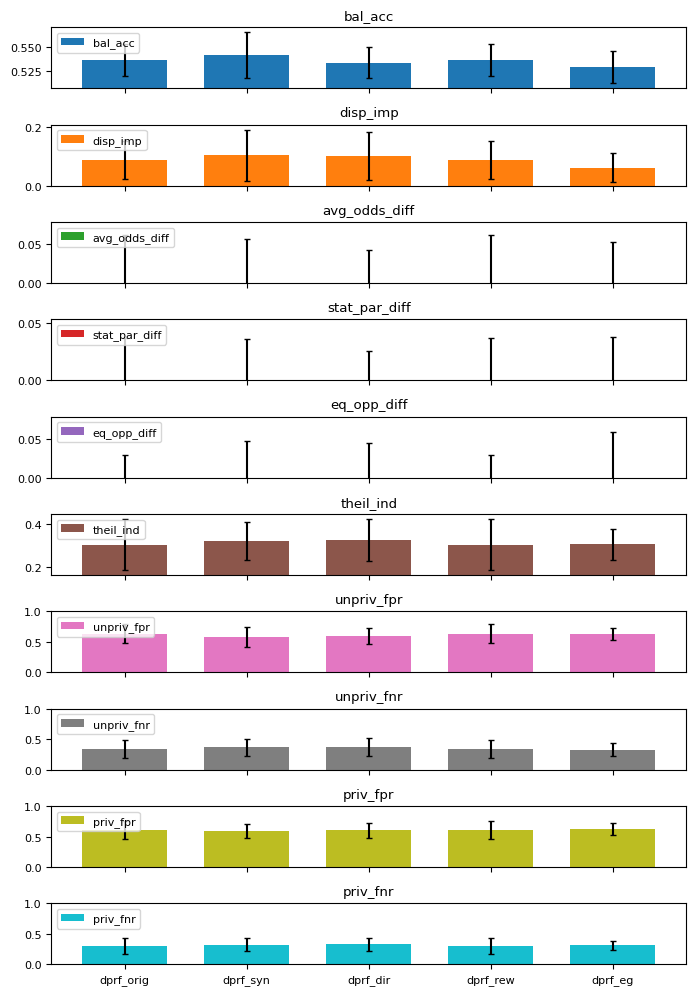

In [58]:
# Plot fairness metrics with error bars
ax = df.plot.bar(
    yerr=df_error, 
    capsize=2, 
    rot=0, 
    subplots=True, 
    title=titles, 
    fontsize=8, 
    figsize=(7, 10),  
    legend=True,
    width=0.7  
)

# Adjust Y-axis limits dynamically
for i, subplot in enumerate(ax):
    metric = titles[i]
    y_values = df[metric]
    y_errors = df_error[metric]

    # Compute min and max with error bars included
    y_min = (y_values - y_errors).min()
    y_max = (y_values + y_errors).max()

    # Add padding
    y_range = y_max - y_min
    padding = 0.1 * y_range if y_range > 0 else 0.05  # ensure some space even for flat values

    lower = max(0, y_min - padding)
    upper = y_max + padding

    # Print min and max to check them
    print(f"Metric: {metric:20} | Min: {y_min:.4f} | Max: {y_max:.4f} | Range: ({lower:.4f}, {upper:.4f})")

    # Set Y-axis limits
    subplot.set_ylim([lower, upper])

    # Optional: force specific bounds if needed
    if "fpr" in metric or "fnr" in metric:
        subplot.set_ylim([0, 1])  # Keep 0–1 if needed for these metrics

    # Move legend inside the plot
    subplot.legend(loc='upper left', fontsize=8, frameon=True)

# Better spacing
plt.tight_layout()
plt.show()

## Save Results

In [59]:
# List of method names corresponding to results/errors
method_names = ["orig", "transf", "dir", "rew", "eg"]

# Initialize a list to hold data for the DataFrame
fairness_data = []

# Populate the data list with metrics and errors
for method, metric, error in zip(method_names, results, errors):
    for key in metric.keys():
        fairness_data.append({
            "Method": method,
            "Metric": key,
            "Mean": metric[key][0],  # Assuming the metric values are single-item lists
            "Error": error[key][0]   # Assuming the error values are single-item lists
        })

# Create DataFrame from the data list
fairness_df = pd.DataFrame(fairness_data)

# File path with today's date
today = datetime.now().strftime('%Y-%m-%d')
file_path = f"./dprf_mia1_results/{BASELINE}_{ATTACK}_{DATASET}_fairness_metrics_{today}_depth15_eps1.csv"

# Save the DataFrame to CSV
fairness_df.to_csv(file_path, index=True)

print(f"File saved at: {file_path}")

File saved at: ./dprf_mia1_results/dprf_mia1_german_age_fairness_metrics_2025-04-01_depth15_eps1.csv


## Visualization of MIA results


### Visualization of MIA Attacks against various Fairness Techniques

#### Privacy risk subpopulations vs Fairness with cross validation

In [60]:
# dataframe to display fairness metrics
# error metrics
%matplotlib inline
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in cpp_metrics.items() if k.endswith("_mia_privacy_risk")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}

In [61]:
# Visualization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
           orig_mia_error_metrics,
           transf_mia_metrics_mean,
           transf_mia_error_metrics,
           dir_mia_metrics_mean,
           dir_mia_error_metrics,
           reweigh_mia_metrics_mean,
           reweigh_mia_error_metrics,
           eg_mia_metrics_mean,
           eg_mia_error_metrics
          ]

index = pd.Series(['orig'] + ['orig_std'] + ['syn'] + ['syn_std'] + ['dir'] + ['dir_std'] + ['rew'] + 
                  ['rew_std'] + ['eg'] + ['eg_std'], name='Classifier MIA Attacks')
#                   + ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_privacy_risk,entire_dataset_label_0.0_mia_privacy_risk,entire_dataset_label_1.0_mia_privacy_risk,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,,,,
orig,0.535700,0.551481,0.539745,0.576745,0.565139,0.553122,0.538953
orig_std,0.011051,0.021803,0.013278,0.037399,0.037665,0.023910,0.015619
syn,0.530700,0.539280,0.537837,0.548700,0.570435,0.544867,0.536857
syn_std,0.015516,0.027321,0.015214,0.035548,0.039437,0.028409,0.015292
dir,0.535800,0.540882,0.543924,0.561174,0.562035,0.543856,0.544778
dir_std,0.009412,0.015866,0.013114,0.029779,0.043597,0.023125,0.011711
rew,0.535700,0.551481,0.539745,0.576745,0.565139,0.553122,0.538953
rew_std,0.011051,0.021803,0.013278,0.037399,0.037665,0.023910,0.015619
eg,0.537800,0.551826,0.544444,0.582983,0.585977,0.556851,0.544585


In [62]:
results = [orig_mia_metrics_mean,
           transf_mia_metrics_mean,
           dir_mia_metrics_mean,
           reweigh_mia_metrics_mean,
           eg_mia_metrics_mean,
          ]

errors = [orig_mia_error_metrics,
          transf_mia_error_metrics,
          dir_mia_error_metrics,
          reweigh_mia_error_metrics,
          eg_mia_error_metrics
         ]

In [63]:
df.columns

Index(['entire_dataset_mia_privacy_risk',
       'entire_dataset_label_0.0_mia_privacy_risk',
       'entire_dataset_label_1.0_mia_privacy_risk',
       'subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk'],
      dtype='object')

In [64]:
df_groups = df[['subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
                       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk']]

In [65]:
df_groups = df_groups.rename(columns={'subpopulation_0.0_label_0.0_mia_privacy_risk': 'G0-',
                           'subpopulation_1.0_label_0.0_mia_privacy_risk': 'G1-',
                           'subpopulation_0.0_label_1.0_mia_privacy_risk': 'G0+',
                           'subpopulation_1.0_label_1.0_mia_privacy_risk': 'G1+'})

In [66]:
df_groups

,G0-,G1-,G0+,G1+
Classifier MIA Attacks,,,,
orig,0.576745,0.553122,0.565139,0.538953
orig_std,0.037399,0.023910,0.037665,0.015619
syn,0.548700,0.544867,0.570435,0.536857
syn_std,0.035548,0.028409,0.039437,0.015292
dir,0.561174,0.543856,0.562035,0.544778
dir_std,0.029779,0.023125,0.043597,0.011711
rew,0.576745,0.553122,0.565139,0.538953
rew_std,0.037399,0.023910,0.037665,0.015619
eg,0.582983,0.556851,0.585977,0.544585


<Axes: xlabel='Classifier MIA Attacks'>

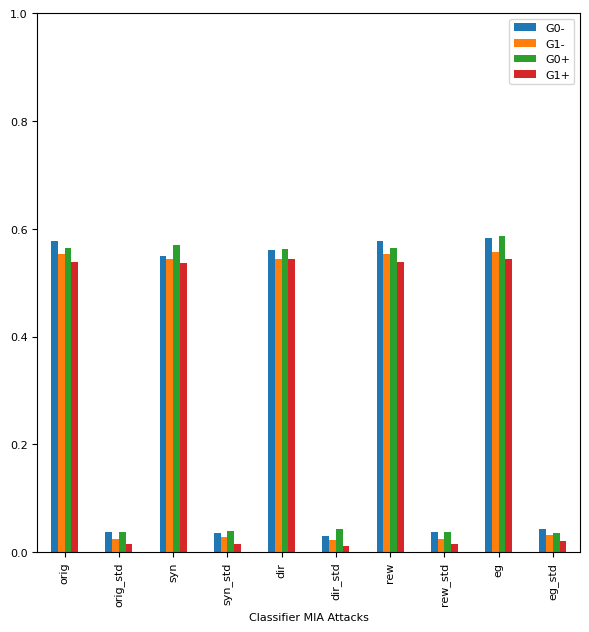

In [67]:
df_groups.plot.bar(figsize=(7,7), ylim=[0,1])

In [68]:
# Tabular Format
# importing the modules
from tabulate import tabulate

 
# displaying the DataFrame
print(tabulate(df_groups.T, headers = 'keys', tablefmt = 'simple'))

         orig    orig_std       syn    syn_std       dir    dir_std       rew    rew_std        eg     eg_std
---  --------  ----------  --------  ---------  --------  ---------  --------  ---------  --------  ---------
G0-  0.576745   0.0373987  0.5487    0.0355482  0.561174  0.0297794  0.576745  0.0373987  0.582983  0.0428604
G1-  0.553122   0.02391    0.544867  0.0284088  0.543856  0.0231249  0.553122  0.02391    0.556851  0.0324103
G0+  0.565139   0.0376645  0.570435  0.0394367  0.562035  0.0435966  0.565139  0.0376645  0.585977  0.0364053
G1+  0.538953   0.0156195  0.536857  0.0152917  0.544778  0.0117113  0.538953  0.0156195  0.544585  0.0213792


## Save Results

In [69]:
errors

[{'entire_dataset_mia_privacy_risk': 0.01105060131728968,
  'entire_dataset_label_0.0_mia_privacy_risk': 0.02180333176029751,
  'entire_dataset_label_1.0_mia_privacy_risk': 0.013277767732657993,
  'subpopulation_0.0_label_0.0_mia_privacy_risk': 0.03739865187167419,
  'subpopulation_0.0_label_1.0_mia_privacy_risk': 0.037664548149292564,
  'subpopulation_1.0_label_0.0_mia_privacy_risk': 0.02391004662717222,
  'subpopulation_1.0_label_1.0_mia_privacy_risk': 0.01561949076991955},
 {'entire_dataset_mia_privacy_risk': 0.015516035847504758,
  'entire_dataset_label_0.0_mia_privacy_risk': 0.027320958975597616,
  'entire_dataset_label_1.0_mia_privacy_risk': 0.015213674514477728,
  'subpopulation_0.0_label_0.0_mia_privacy_risk': 0.03554821525812899,
  'subpopulation_0.0_label_1.0_mia_privacy_risk': 0.03943667796787429,
  'subpopulation_1.0_label_0.0_mia_privacy_risk': 0.02840880129781288,
  'subpopulation_1.0_label_1.0_mia_privacy_risk': 0.015291706467722026},
 {'entire_dataset_mia_privacy_risk':

In [70]:
# List of method names corresponding to results/errors
method_names = ["orig", "transf", "dir", "rew", "eg"]

# Initialize a list to hold data for the DataFrame
pr_data = []

# Populate the data list with metrics and errors
for method, metric, error in zip(method_names, results, errors):
    for key in metric.keys():
        pr_data.append({
            "Method": method,
            "Metric": key,
            "Mean Privacy Risk": metric[key],  # Privacy risk mean
            "Error": error[key]               # Privacy risk error
        })

# Create DataFrame from the data list
pr_df = pd.DataFrame(pr_data)

# File path with today's date
today = datetime.now().strftime('%Y-%m-%d')
file_path = f"./dprf_mia1_results/{BASELINE}_{ATTACK}_{DATASET}_mia_privacy_risks_metrics_{today}_depth15_eps1.csv"

# Save the DataFrame to CSV
pr_df.to_csv(file_path, index=True)

print(f"File saved at: {file_path}")

File saved at: ./dprf_mia1_results/dprf_mia1_german_age_mia_privacy_risks_metrics_2025-04-01_depth15_eps1.csv


# Main Bar Graph Visualization

In [71]:
# Subpopulations and fairness methods
subpopulations = {
    'subpopulation_0.0_label_0.0_mia_privacy_risk': "Unprivileged Unfavorable", 
    'subpopulation_0.0_label_1.0_mia_privacy_risk': "Unprivileged Favorable", 
    'subpopulation_1.0_label_0.0_mia_privacy_risk': "Privileged Unfavorable",
    'subpopulation_1.0_label_1.0_mia_privacy_risk': "Privileged Favorable"
}

fairness_methods = ["syn", "dir", "rew", "eg"]

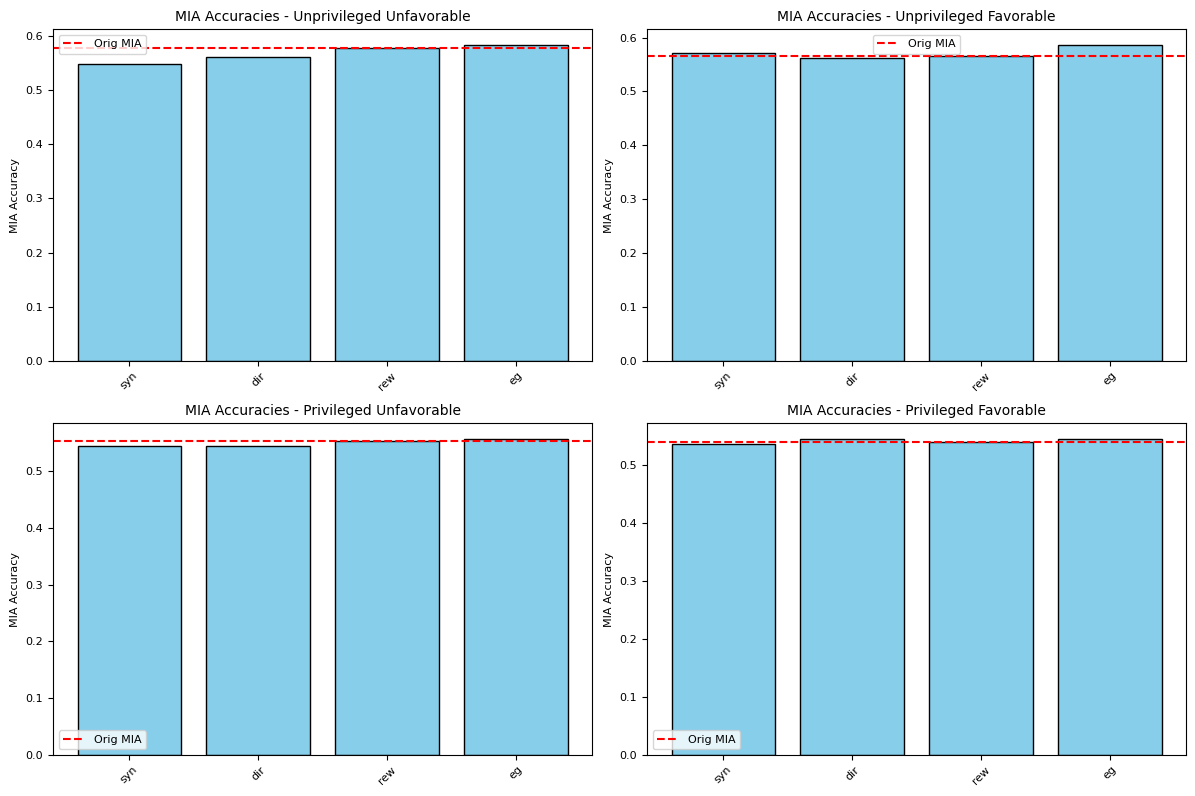

In [72]:
# Combine results into a list
all_results = [
    transf_mia_metrics_mean,
    dir_mia_metrics_mean,
    reweigh_mia_metrics_mean,
    eg_mia_metrics_mean
]

# Organize data for plotting
data = {subpopulations[key]: [results[key] for results in all_results] for key in subpopulations.keys()}
orig_values = orig_mia_metrics_mean

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()
idx = 0

for key, value in subpopulations.items():
    accuracies = data[value]
    ax = axes[idx]
    
    # Plot bar chart (excluding 'orig')
    ax.bar(fairness_methods, accuracies, color='skyblue', edgecolor='black')
    
    # Add dashed line for 'orig' MIA accuracy
    ax.axhline(orig_values[key], color='red', linestyle='--', label='Orig MIA')
    
    # Title and labels
    ax.set_title(f"MIA Accuracies - {value}", fontsize=10)
    ax.set_ylabel("MIA Accuracy")
    ax.set_xticks(np.arange(len(fairness_methods)))
    ax.set_xticklabels(fairness_methods, rotation=45)
    ax.legend()
    
    idx = idx + 1

plt.tight_layout()
plt.show()

### Visualizing using novel technique

In [73]:
orig_mia_error_metrics = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
#orig_mia_metrics

In [74]:
advantage_metrics_arrays = []
for key in orig_mia_error_metrics.keys():
    for val in orig_mia_metrics[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in eg_mia_error_metrics.keys():
    for val in eg_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["eg", key.replace("_mia_attacker_advantage", ""), val])

In [75]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "Privacy Risk"])
df

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.542000
1,orig,entire_dataset_mia_privacy_risk,0.540000
2,orig,entire_dataset_mia_privacy_risk,0.530000
3,orig,entire_dataset_mia_privacy_risk,0.529000
4,orig,entire_dataset_mia_privacy_risk,0.544000
...,...,...,...
695,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.549425
696,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.523685
697,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.552864
698,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.519166


In [76]:
# keep only subgroups
df_subgroups = df[~((df["MIA"] == "entire_dataset_label_0.0_mia_privacy_risk") | (df["MIA"] == "entire_dataset_label_1.0_mia_privacy_risk")) ]
df_subgroups

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.542000
1,orig,entire_dataset_mia_privacy_risk,0.540000
2,orig,entire_dataset_mia_privacy_risk,0.530000
3,orig,entire_dataset_mia_privacy_risk,0.529000
4,orig,entire_dataset_mia_privacy_risk,0.544000
...,...,...,...
695,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.549425
696,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.523685
697,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.552864
698,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.519166


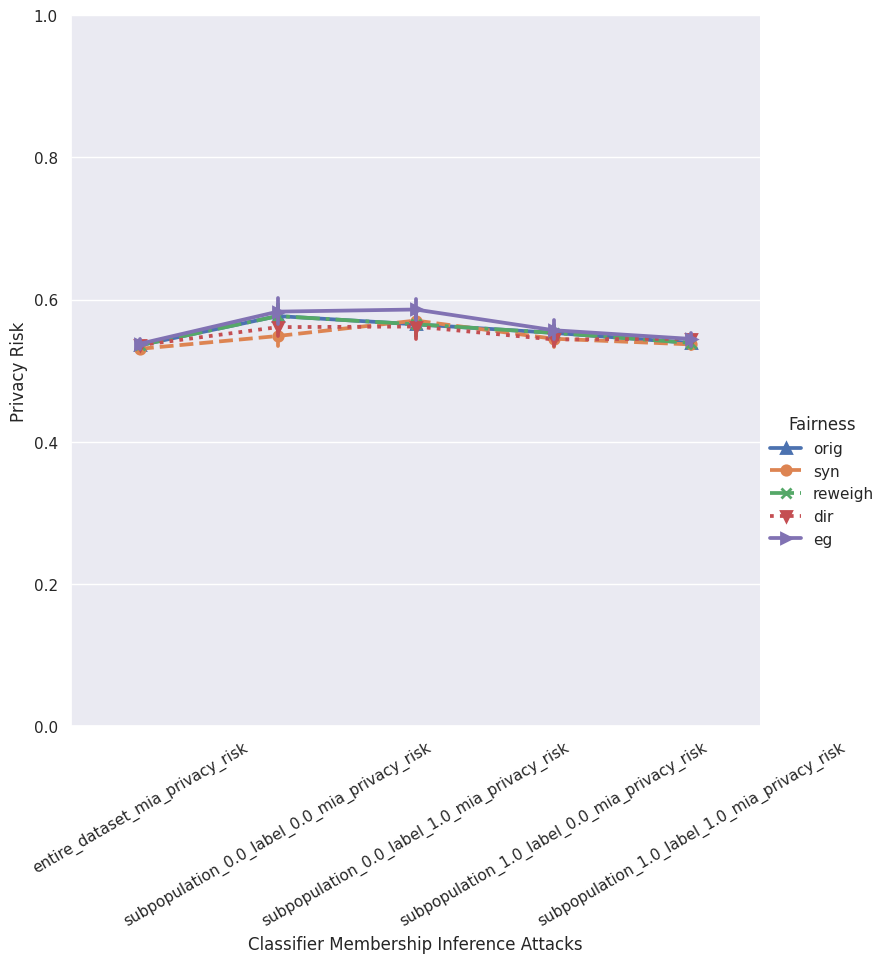

In [77]:
#plt.figure(figsize=(15,8))
import seaborn as sns

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df_subgroups, x="MIA", y="Privacy Risk", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Privacy Risk" )
g.set(ylim=(0, 1))

### ROC curves and AUC scores with cross validation

In [78]:
from sklearn.metrics import RocCurveDisplay, auc

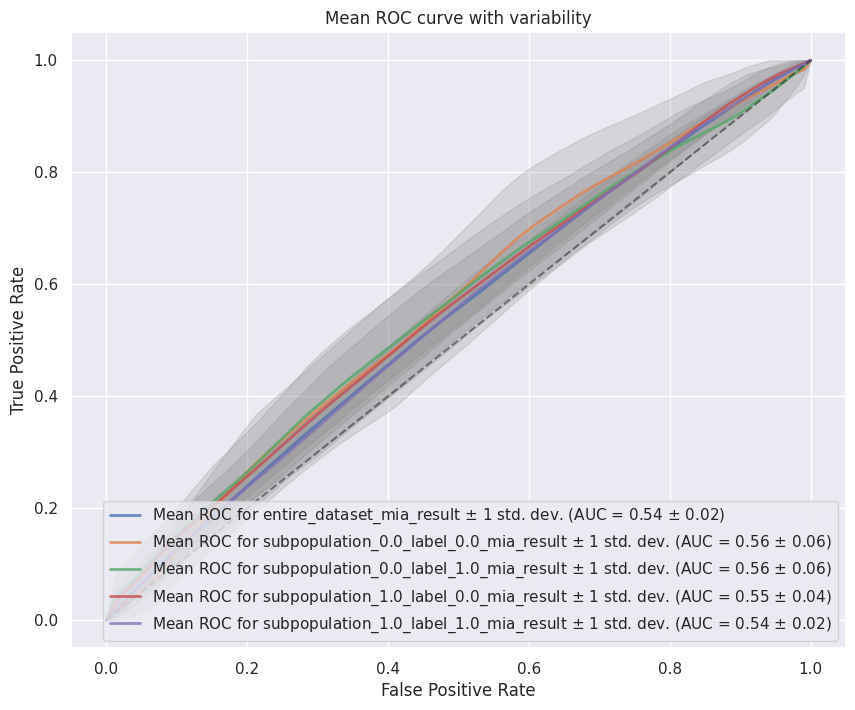

In [79]:
# for orig dataset with different subpopulations
fig, ax = plt.subplots(figsize=(10, 8))

for key in ["entire_dataset_mia_result", 
            "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", 
            "subpopulation_1.0_label_0.0_mia_result",
            "subpopulation_1.0_label_1.0_mia_result"]:
     # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
    # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
    tprs = []
    
    # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
    aucs = []

    # mean_fpr = np.mean(fprs, axis=0)
    mean_fpr = np.linspace(0, 1, 100)
    
    for mia_res in orig_mia_metrics[key]:
        interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(mia_res.get_auc())
    
    #print(mean_fpr)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    ax.plot(
        mean_fpr,
        mean_tpr,
        #color="b",
        label=r"Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % ( key ,mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        #label=r"$\pm$ 1 std. dev.",
    )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.legend(loc="lower right")
plt.show()

MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 500, Test = 500
  AUC: 0.54
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.53
  Test Accuracy (TNR): 0.56
  Attacker advantage: 0.08
  Positive predictive value: 1.00
  Optimal thershold: -0.5108256237659907
)
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 500, Test = 500
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.55
  Test Accuracy (TNR): 0.53
  Attacker advantage: 0.08
  Positive predictive value: 0.54
  Optimal thershold: -0.5108256237659907
)
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 500, Test = 500
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.06
  Positive predictive value: 0.69
  Optimal thershold: -0.916290731874155
)
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 500, Test = 500
  AUC: 0.53
  Privacy Risk: 0.53
  Accur

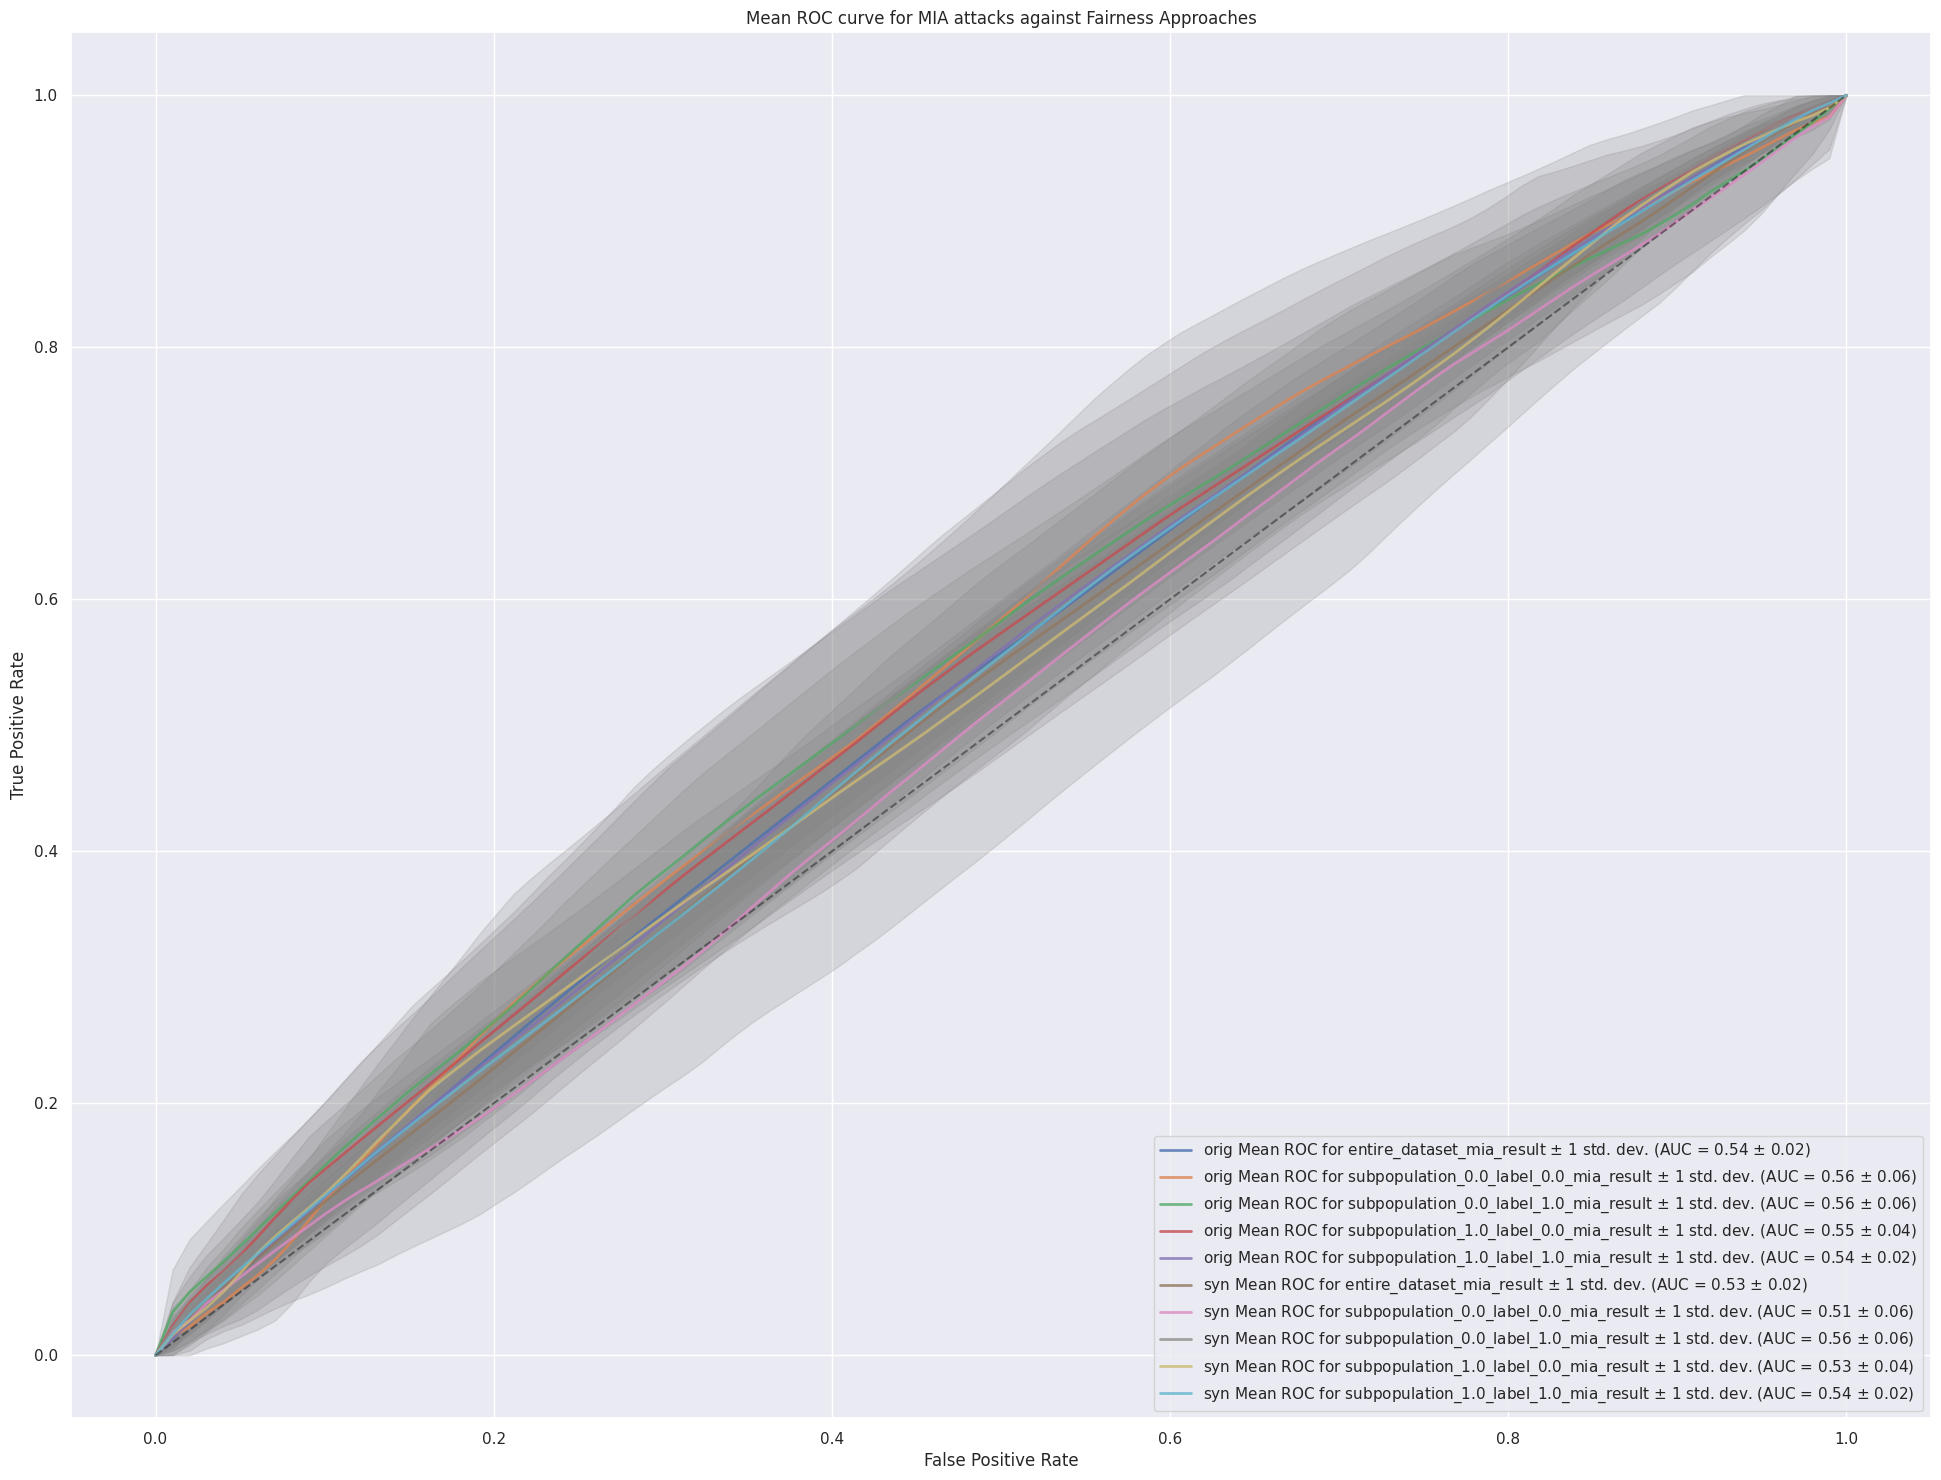

In [80]:
# for entire dataset with different subpopulations
# fig, ax = plt.subplots(figsize=(12, 10))
fig, ax = plt.subplots(figsize=(24, 18))

for mia_metrics, name in zip([orig_mia_metrics, transf_mia_metrics], ["orig", "syn"]): 
#                               dir_mia_metrics, reweigh_mia_metrics], ["orig", "syn", "dir", "reweigh"] ):
    for key in ["entire_dataset_mia_result", 
                "subpopulation_0.0_label_0.0_mia_result",
                "subpopulation_0.0_label_1.0_mia_result", 
                "subpopulation_1.0_label_0.0_mia_result",
                "subpopulation_1.0_label_1.0_mia_result"]:
   
        # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
        # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
        tprs = []
        # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
        aucs = []

        # mean_fpr = np.mean(fprs, axis=0)
        mean_fpr = np.linspace(0, 1, 100)

        for mia_res in mia_metrics[key]:
            print(mia_res)
            interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(mia_res.get_auc())

        #print(mean_fpr)
        print(tprs)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0

        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)

        ax.plot(
            mean_fpr,
            mean_tpr,
            #color="b",
            label=r"%s Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % (name, key ,mean_auc, std_auc),
            lw=2,
            alpha=0.8,
        )

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            #label=r"$\pm$ 1 std. dev.",
        )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve for MIA attacks against Fairness Approaches",
)
ax.legend(loc="lower right")
# ax.legend(loc="upper left")

plt.show()

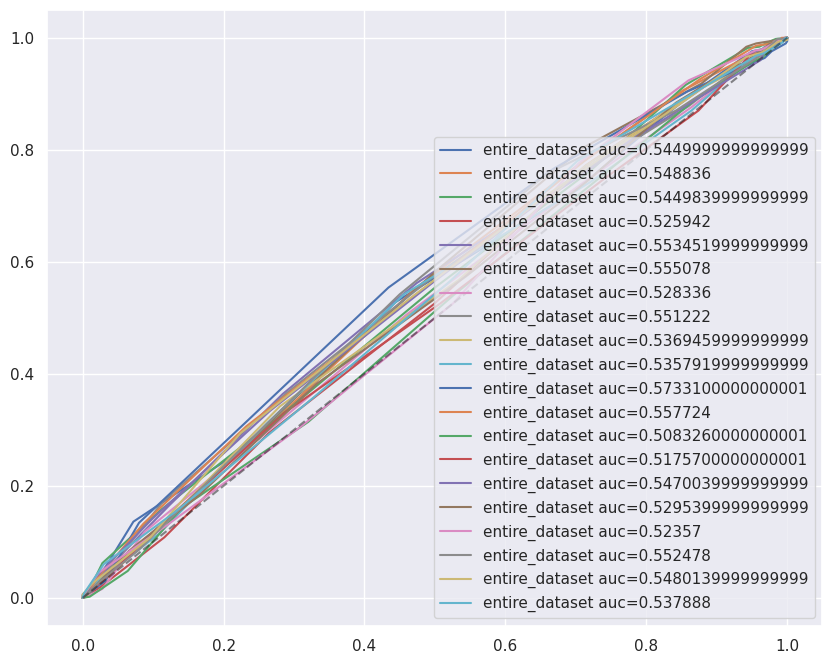

In [81]:
# for entire dataset
plt.figure(figsize=(10,8))

for mia_res in orig_mia_metrics["entire_dataset_mia_result"]:
    plt.plot(mia_res.fpr,mia_res.tpr,label=f"{mia_res.get_name()} auc={mia_res.get_auc()}")

plt.plot([0, 1], [0, 1],'k--', alpha=0.5)
plt.legend(loc=0)

## MIA Attacks AUC vs Fairness Bar Chart 

In [82]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("mia_auc")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("mia_auc")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("mia_auc")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_auc")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("mia_auc")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("mia_auc")}

In [83]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
        eg_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_auc,entire_dataset_label_0.0_mia_auc,entire_dataset_label_1.0_mia_auc,subpopulation_0.0_label_0.0_mia_auc,subpopulation_0.0_label_1.0_mia_auc,subpopulation_1.0_label_0.0_mia_auc,subpopulation_1.0_label_1.0_mia_auc
Classifier MIA Attacks,,,,,,,
orig,0.541051,0.554084,0.543764,0.557429,0.555824,0.552664,0.540921
syn,0.532158,0.527432,0.541090,0.508893,0.557543,0.534083,0.537988
dir,0.540902,0.541357,0.549403,0.545674,0.548012,0.539539,0.548979
rew,0.541051,0.554084,0.543764,0.557429,0.555824,0.552664,0.540921
egr,0.525889,0.534115,0.533907,0.533172,0.562347,0.533749,0.528630


<Axes: xlabel='Classifier MIA Attacks'>

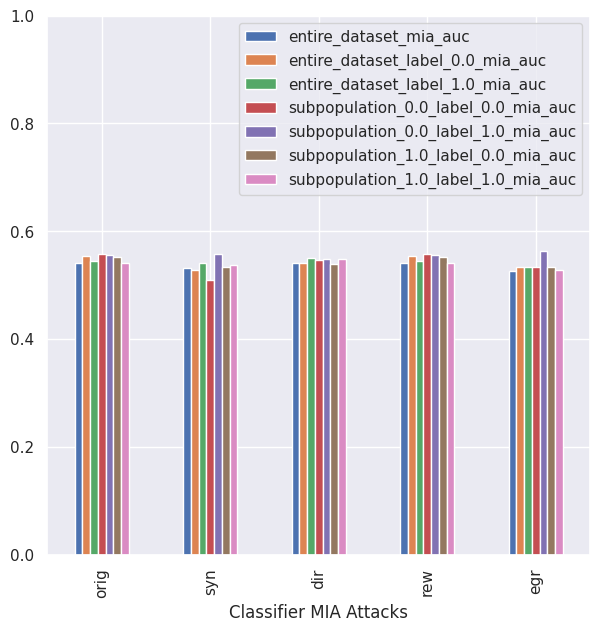

In [84]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

###  MIA Attackers Advantage Metrics

In [85]:
# Creating data structures to plot point categorical plot from seaborn

In [86]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("attacker_advantage")}

In [87]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_attacker_advantage", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.08400000000000002],
 ['orig', 'entire_dataset', 0.08000000000000007],
 ['orig', 'entire_dataset', 0.06000000000000005],
 ['orig', 'entire_dataset', 0.05800000000000005],
 ['orig', 'entire_dataset', 0.08800000000000008],
 ['orig', 'entire_dataset', 0.09400000000000008],
 ['orig', 'entire_dataset', 0.045999999999999985],
 ['orig', 'entire_dataset', 0.07600000000000001],
 ['orig', 'entire_dataset', 0.062],
 ['orig', 'entire_dataset', 0.08600000000000002],
 ['orig', 'entire_dataset', 0.12000000000000005],
 ['orig', 'entire_dataset', 0.07399999999999998],
 ['orig', 'entire_dataset', 0.020000000000000018],
 ['orig', 'entire_dataset', 0.04400000000000004],
 ['orig', 'entire_dataset', 0.068],
 ['orig', 'entire_dataset', 0.04999999999999999],
 ['orig', 'entire_dataset', 0.07200000000000006],
 ['orig', 'entire_dataset', 0.09799999999999998],
 ['orig', 'entire_dataset', 0.07],
 ['orig', 'entire_dataset', 0.07800000000000007],
 ['orig', 'entire_dataset_label_0.0', 0.1

In [88]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "attacker_advantage"])
df

,Fairness,MIA,attacker_advantage
0,orig,entire_dataset,0.084000
1,orig,entire_dataset,0.080000
2,orig,entire_dataset,0.060000
3,orig,entire_dataset,0.058000
4,orig,entire_dataset,0.088000
...,...,...,...
695,egr,subpopulation_1.0_label_1.0,0.098851
696,egr,subpopulation_1.0_label_1.0,0.047371
697,egr,subpopulation_1.0_label_1.0,0.105728
698,egr,subpopulation_1.0_label_1.0,0.038332


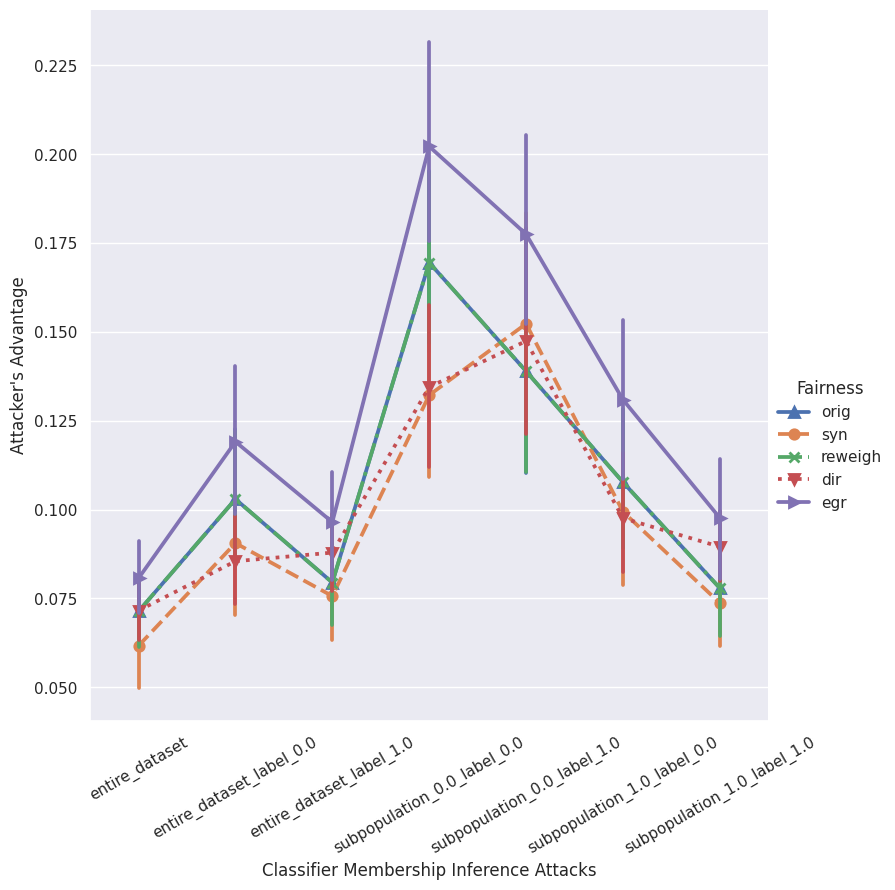

In [89]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)
g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )


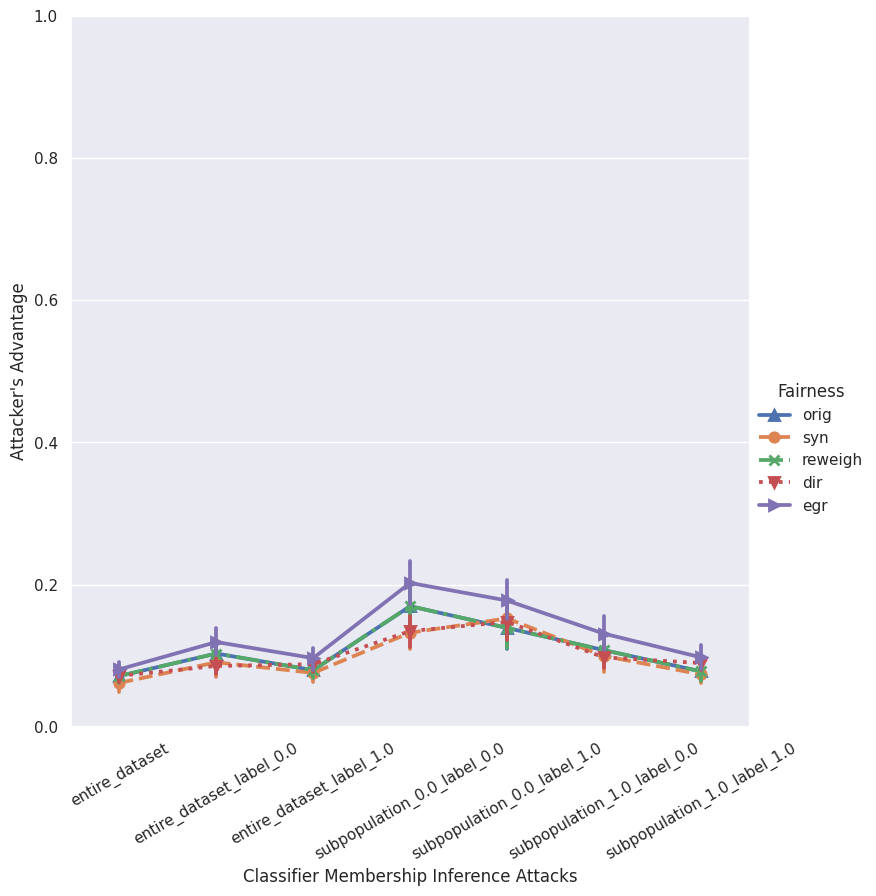

In [90]:
#plt.figure(figsize=(15,8))

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )
g.set(ylim=(0, 1))

In [91]:
pd.DataFrame(orig_mia_metrics_att_ad)

,entire_dataset_mia_attacker_advantage,entire_dataset_label_0.0_mia_attacker_advantage,entire_dataset_label_1.0_mia_attacker_advantage,subpopulation_0.0_label_0.0_mia_attacker_advantage,subpopulation_0.0_label_1.0_mia_attacker_advantage,subpopulation_1.0_label_0.0_mia_attacker_advantage,subpopulation_1.0_label_1.0_mia_attacker_advantage
0,0.084,0.117044,0.100412,0.180451,0.053333,0.090000,0.124598
1,0.080,0.145258,0.076324,0.199246,0.129915,0.127273,0.071813
2,0.060,0.137119,0.077012,0.189394,0.093719,0.119061,0.085710
3,0.058,0.083929,0.029412,0.125000,0.107677,0.156667,0.016450
4,0.088,0.108344,0.112602,0.194236,0.130000,0.191799,0.111221
5,0.094,0.152077,0.056487,0.244444,0.142857,0.127616,0.063397
6,0.046,0.057058,0.048419,0.083177,0.084218,0.057692,0.041961
7,0.076,0.080128,0.105468,0.082552,0.188492,0.081985,0.090000
8,0.062,0.129437,0.102098,0.225000,0.249339,0.097004,0.074688
9,0.086,0.092441,0.094874,0.123737,0.170000,0.084078,0.076264


In [92]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("attacker_advantage")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("attacker_advantage")}

In [93]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
           eg_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_attacker_advantage,entire_dataset_label_0.0_mia_attacker_advantage,entire_dataset_label_1.0_mia_attacker_advantage,subpopulation_0.0_label_0.0_mia_attacker_advantage,subpopulation_0.0_label_1.0_mia_attacker_advantage,subpopulation_1.0_label_0.0_mia_attacker_advantage,subpopulation_1.0_label_1.0_mia_attacker_advantage
Classifier MIA Attacks,,,,,,,
orig,0.0714,0.102962,0.079490,0.169511,0.138948,0.107721,0.077913
syn,0.0617,0.090583,0.075675,0.132221,0.152308,0.099413,0.073714
dir,0.0716,0.085481,0.087915,0.134491,0.147439,0.097590,0.089557
rew,0.0714,0.102962,0.079490,0.169511,0.138948,0.107721,0.077913
egr,0.0807,0.119121,0.096479,0.202209,0.177512,0.130935,0.097651


<Axes: xlabel='Classifier MIA Attacks'>

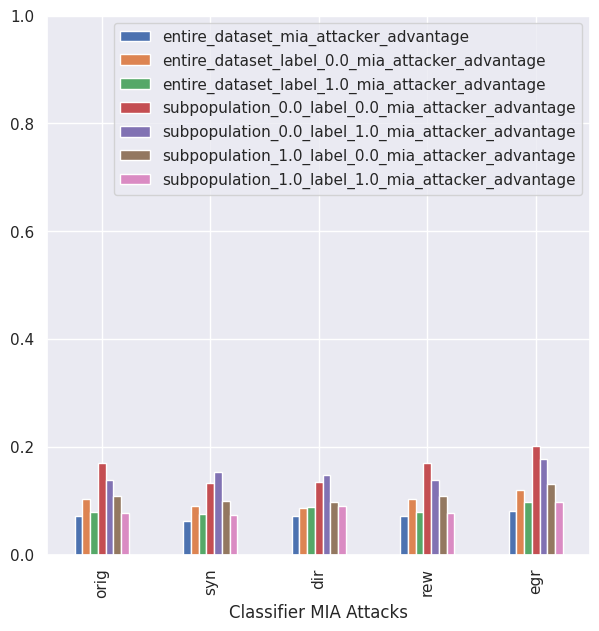

In [94]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

## PPV Metric

In [95]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("mia_ppv")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("mia_ppv")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_ppv")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("mia_ppv")}
egr_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("mia_ppv")}

In [96]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_ppv", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_ppv", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_ppv", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_ppv", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_ppv", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 1.0],
 ['orig', 'entire_dataset', 0.5391304347826087],
 ['orig', 'entire_dataset', 0.6888888888888889],
 ['orig', 'entire_dataset', 0.5268817204301075],
 ['orig', 'entire_dataset', 0.6],
 ['orig', 'entire_dataset', 0.5744680851063829],
 ['orig', 'entire_dataset', 0.5728155339805825],
 ['orig', 'entire_dataset', 1.0],
 ['orig', 'entire_dataset', 0.5498392282958199],
 ['orig', 'entire_dataset', 0.6666666666666666],
 ['orig', 'entire_dataset', 0.6261682242990654],
 ['orig', 'entire_dataset', 0.6296296296296297],
 ['orig', 'entire_dataset', 0.5333333333333332],
 ['orig', 'entire_dataset', 0.5378787878787878],
 ['orig', 'entire_dataset', 0.6666666666666667],
 ['orig', 'entire_dataset', 0.5599999999999999],
 ['orig', 'entire_dataset', 1.0],
 ['orig', 'entire_dataset', 0.5463709677419355],
 ['orig', 'entire_dataset', 1.0],
 ['orig', 'entire_dataset', 0.8],
 ['orig', 'entire_dataset_label_0.0', 0.6116504854368932],
 ['orig', 'entire_dataset_label_0.0', 0.77777777777

In [97]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "PPV"])
df

,Fairness,MIA,PPV
0,orig,entire_dataset,1.000000
1,orig,entire_dataset,0.539130
2,orig,entire_dataset,0.688889
3,orig,entire_dataset,0.526882
4,orig,entire_dataset,0.600000
...,...,...,...
695,egr,subpopulation_1.0_label_1.0,1.000000
696,egr,subpopulation_1.0_label_1.0,1.000000
697,egr,subpopulation_1.0_label_1.0,1.000000
698,egr,subpopulation_1.0_label_1.0,0.636364


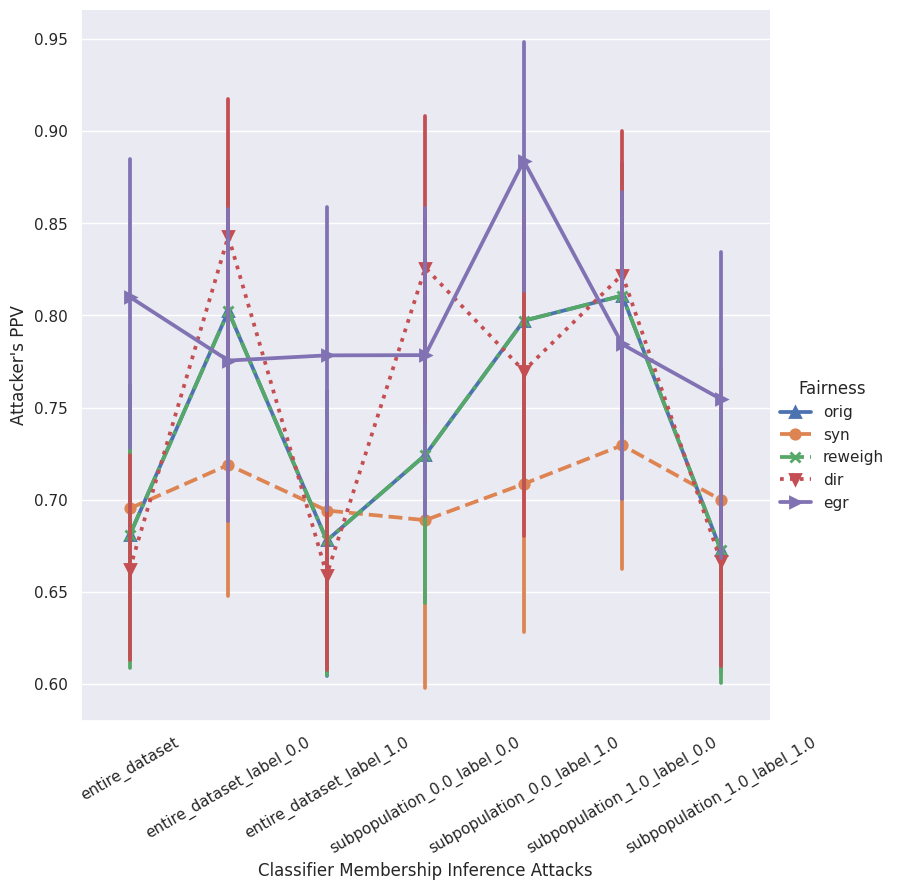

In [98]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="PPV", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's PPV" )
